<a href="https://colab.research.google.com/github/AvaterClasher/Multi_Classification_Model_GPU/blob/main/Multi_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a toy multi-class dataset

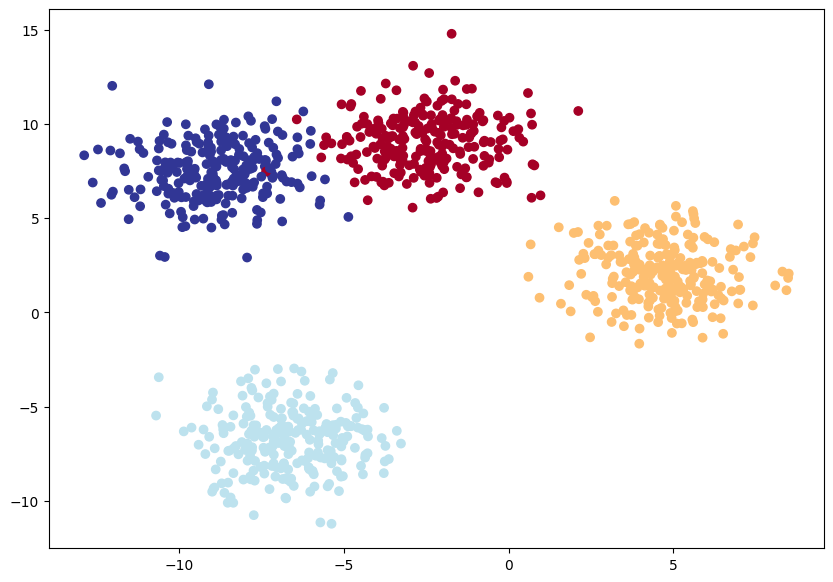

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torch import nn

# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter you can change


In [5]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


In [6]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.1139,  0.0473,  1.3754,  0.4784],
        [-0.0556, -1.8171, -0.6538,  0.0658],
        [ 0.2383, -0.7956, -1.2918, -1.1586],
        [-0.0361,  0.0889,  0.9962,  0.1357],
        [-0.1916, -0.9149,  0.9072,  0.7455],
        [-0.0611, -2.1111, -0.8944,  0.0665],
        [ 0.2380, -0.5022, -1.0202, -1.1333],
        [-0.1505, -1.1333,  0.4855,  0.5446],
        [ 0.2564, -1.2159, -1.7759, -1.2737],
        [-0.1621, -1.0402,  0.6334,  0.6038]], device='cuda:0')

In [7]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1139,  0.0473,  1.3754,  0.4784],
        [-0.0556, -1.8171, -0.6538,  0.0658],
        [ 0.2383, -0.7956, -1.2918, -1.1586],
        [-0.0361,  0.0889,  0.9962,  0.1357],
        [-0.1916, -0.9149,  0.9072,  0.7455]], device='cuda:0')
tensor([[0.1188, 0.1396, 0.5268, 0.2148],
        [0.3508, 0.0603, 0.1929, 0.3961],
        [0.5496, 0.1955, 0.1190, 0.1359],
        [0.1632, 0.1849, 0.4581, 0.1938],
        [0.1421, 0.0689, 0.4263, 0.3627]], device='cuda:0')


In [8]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 3, 0, 2, 2, 3, 0, 3, 0, 2, 3, 2, 2, 3, 3, 3, 3, 0, 3, 0, 3, 3, 2, 0,
        0, 0, 3, 2, 2, 3, 3, 2, 2, 0, 2, 0, 2, 0, 2, 0, 3, 0, 3, 0, 3, 3, 2, 2,
        3, 3, 2, 3, 2, 2, 0, 0, 2, 2, 3, 0, 0, 2, 0, 0, 0, 3, 3, 3, 3, 2, 2, 3,
        0, 3, 0, 3, 0, 3, 3, 2, 3, 0, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 3,
        2, 3, 3, 0, 3, 3, 3, 3, 0, 3, 2, 3, 3, 0, 2, 2, 3, 0, 0, 3, 3, 2, 2, 0,
        0, 3, 2, 2, 0, 3, 3, 3, 0, 3, 2, 0, 3, 0, 3, 3, 3, 3, 2, 2, 2, 3, 0, 0,
        0, 0, 3, 3, 3, 0, 0, 2, 0, 0, 3, 2, 3, 3, 0, 2, 0, 3, 3, 0, 3, 0, 0, 3,
        0, 0, 0, 3, 3, 2, 2, 2, 2, 2, 0, 2, 3, 0, 0, 2, 0, 0, 3, 2, 0, 0, 3, 3,
        2, 3, 0, 3, 3, 2, 0, 2], device='cuda:0')

In [9]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.6055, Acc: 18.25% | Test loss: 0.7121, Test acc: 71.00%
Epoch: 10 | Loss: 0.1692, Acc: 98.88% | Test loss: 0.1524, Test acc: 99.50%
Epoch: 20 | Loss: 0.0898, Acc: 99.12% | Test loss: 0.0811, Test acc: 99.00%
Epoch: 30 | Loss: 0.0643, Acc: 99.12% | Test loss: 0.0565, Test acc: 99.50%
Epoch: 40 | Loss: 0.0524, Acc: 99.12% | Test loss: 0.0446, Test acc: 99.50%
Epoch: 50 | Loss: 0.0457, Acc: 99.00% | Test loss: 0.0377, Test acc: 99.50%
Epoch: 60 | Loss: 0.0414, Acc: 99.00% | Test loss: 0.0332, Test acc: 99.50%
Epoch: 70 | Loss: 0.0384, Acc: 99.00% | Test loss: 0.0301, Test acc: 99.50%
Epoch: 80 | Loss: 0.0363, Acc: 99.00% | Test loss: 0.0278, Test acc: 99.50%
Epoch: 90 | Loss: 0.0347, Acc: 99.12% | Test loss: 0.0260, Test acc: 99.50%


In [10]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  7.0359,  12.8141, -10.2110,  -6.3935],
        [  1.9569, -14.5117,   0.3051,   7.5651],
        [-10.8754, -18.3443,  16.3447,   8.0024],
        [  3.3606,   8.8617,  -5.1561,  -4.7435],
        [  9.5818,   4.9342, -11.9980,  -1.8652],
        [  1.8636, -17.9679,   0.9753,   9.3995],
        [-10.5017, -14.5567,  15.2840,   6.0261],
        [  7.3442,  -0.2445,  -8.4728,   0.6203],
        [-12.2581, -24.7906,  19.0473,  11.2721],
        [  8.0138,   1.6210,  -9.5787,  -0.2922]], device='cuda:0')

In [11]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[3.0849e-03, 9.9691e-01, 9.9765e-11, 4.5384e-09],
        [3.6515e-03, 2.5718e-10, 7.0004e-04, 9.9565e-01],
        [1.5080e-12, 8.6031e-16, 9.9976e-01, 2.3817e-04],
        [4.0659e-03, 9.9593e-01, 8.1351e-07, 1.2291e-06],
        [9.9050e-01, 9.4937e-03, 4.2059e-10, 1.0580e-05],
        [5.3317e-04, 1.3007e-12, 2.1934e-04, 9.9925e-01],
        [6.3291e-12, 1.0971e-13, 9.9990e-01, 9.5345e-05],
        [9.9829e-01, 5.0525e-04, 1.3490e-07, 1.1998e-03],
        [2.5356e-14, 9.1468e-20, 9.9958e-01, 4.1987e-04],
        [9.9808e-01, 1.6704e-03, 2.2848e-08, 2.4657e-04]], device='cuda:0')

In [12]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [13]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

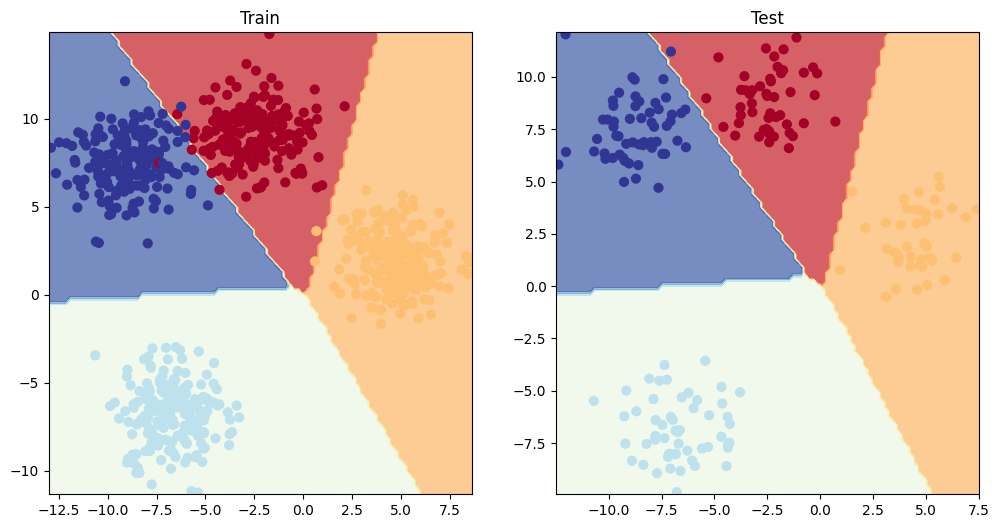

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [15]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 37.0 MB/s eta 0:00:00


In [19]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')